In [300]:
import pandas as pd
from pymongo import MongoClient

STRAVA_DB = "strava_db"

client = MongoClient()

def get_df_from_db_collection(db_name, collection_name):    
    return pd.DataFrame.from_records(client[db_name][collection_name].find())    

data = get_df_from_db_collection(STRAVA_DB, "activities")

In [330]:
import numpy as np

data_solo = data.loc[(data.type == 'Ride') & (data.average_speed > 0) & (data.athlete_count == 1)]
data_with_company = data.loc[(data.type == 'Ride') & (data.average_speed > 0) & (data.athlete_count > 1)]

cols = ['average_speed', 'moving_time', 'distance', 'total_elevation_gain']

data_solo = data_solo[cols]
data_with_company = data_with_company[cols]

def remove_outliers(data):
    z_scores = np.abs((data['average_speed'] - data['average_speed'].mean()) / data['average_speed'].std())    
    return data[z_scores < 1]

data_solo = remove_outliers(data_solo)
data_with_company = remove_outliers(data_with_company)


In [342]:
import time
import math
from sklearn.linear_model import LinearRegression

def run_model(data):
    X = data[['distance', 'total_elevation_gain']]
    y = data['moving_time']

    elapsed_time_model = LinearRegression()
    elapsed_time_model.fit(X, y)

    return elapsed_time_model

solo_model = run_model(data_solo)
company_model = run_model(data_with_company)

sample_to_predict = pd.DataFrame({'distance' : [10000], 'total_elevation_gain': [100]})

prediction_solo = solo_model.predict(sample_to_predict)[0]
prediction_company = company_model.predict(sample_to_predict)[0]

print ('Solo \n Time: {} Speed: {}km/h'.format(time.strftime('%H:%M:%S', time.gmtime(int(prediction_solo))), math.ceil(sample_to_predict['distance'][0] / prediction_solo * 3.6)))
print ('Acompanied \n Time: {} Speed: {}km/h'.format(time.strftime('%H:%M:%S', time.gmtime(int(prediction_company))), math.ceil(sample_to_predict['distance'][0] / prediction_company * 3.6)))


Solo 
 Time: 00:30:10 Speed: 20km/h
Acompanied 
 Time: 00:47:25 Speed: 13km/h


<Axes: xlabel='distance', ylabel='moving_time'>

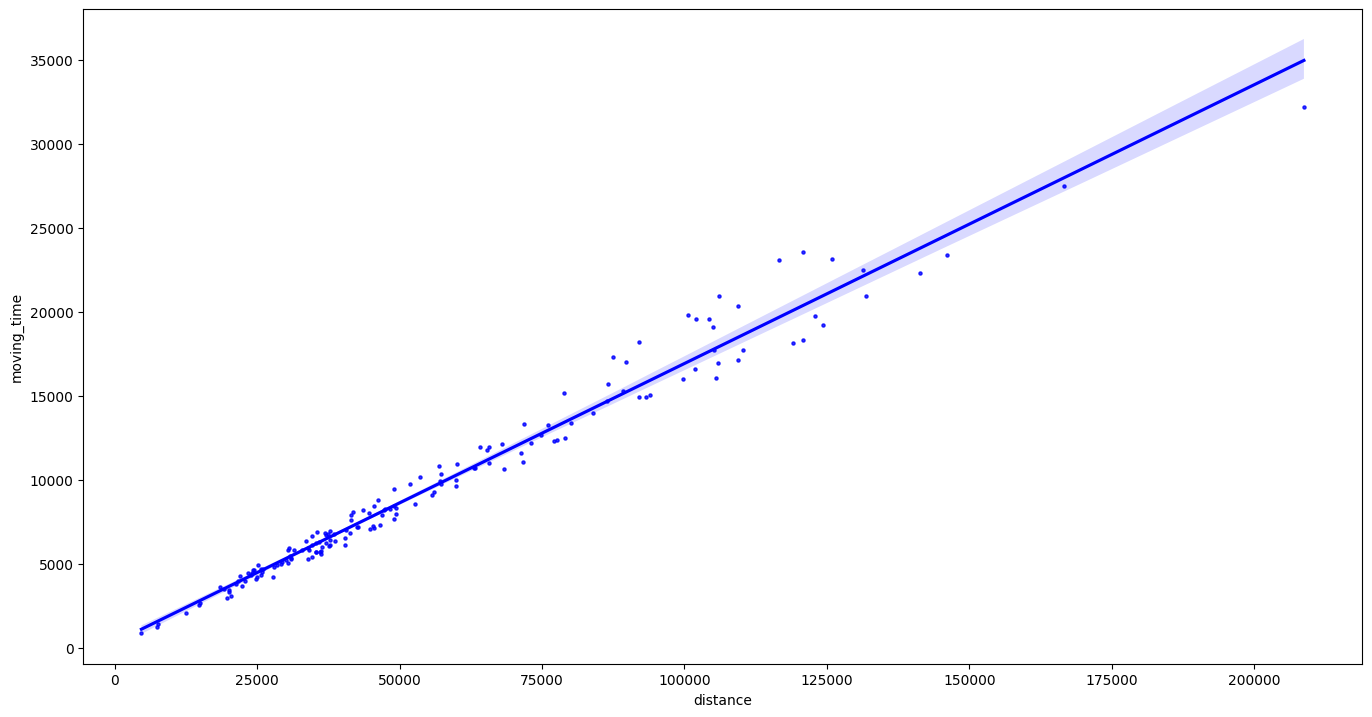

In [331]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(16.5, 8.5)

sns.regplot(x='distance', y='moving_time', data=data_solo, line_kws={'color': 'b'}, scatter_kws={"color": "blue", 's':5}, ax=ax)

#sns.regplot(x='distance', y='moving_time', data=data_with_company, line_kws={'color': 'g'}, scatter_kws={"color": "green", 's':5}, ax=ax)
